<a href="https://colab.research.google.com/github/tony-wade/Qiskit/blob/main/Quantum%20Relation%20Network/QRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import numpy as np
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from torch import Tensor
import torch.nn as nn
import torch
from torch import no_grad
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
#!pip install qiskit
!pip install qiskit-machine-learning
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 6.5 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512707 sha256=42d90d41c380b6baa669f2ba6d101a9b687aaf61083887b18e9fe313ee28472f
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3ac

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_tensor_type('torch.FloatTensor')

In [3]:
# 定義數據增強
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), shear=(5,5)),  # 隨機平移、推移
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.85, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


class CustomMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_name).convert('L')  # 轉成黑白
        image = ImageOps.invert(img)
        label = int(self.image_files[idx].split('.')[0])  # 文件名=tag

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
n_classes = 10    # 類別數
batch_size = 10
num_copies = 30  # 數據增強倍率（每個類別的複製數）
n_query = 10   # 每個類別用於測試的樣本數


# Sample/Support & Training set
#
# Sample: 28*28 10 pics(1-shot)
sample = CustomMNISTDataset('./selfmnist', transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                      ]))

# Train：by data aug.
custom_dataset = CustomMNISTDataset('./selfmnist', transform=transform)
train = [custom_dataset] * num_copies
train = ConcatDataset(train)



# Query set
#
# 加載MNIST dataset(28*28),並從每個類別中隨機選取n_query個樣本
X_query = datasets.MNIST(root='./data', train=True, transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                           ]), download=True)

idx = []
for digit in range(n_classes):
    digit_indices = np.where(X_query.targets == digit)[0]
    selected_indices = random.sample(digit_indices.tolist(), n_query)
    idx.extend(selected_indices)

X_query.data = X_query.data[idx]
X_query.targets = X_query.targets[idx]



# 定義dataloader
#
sample_loader = DataLoader(sample, batch_size=1, shuffle=False)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
query_loader = DataLoader(X_query, batch_size=batch_size, shuffle=True)

In [5]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1, 32, kernel_size=3, bias=False),     # 拆成兩組3*3kernel表現會比一個5*5好,接BN則不需bias
                        nn.BatchNorm2d(32, momentum=1, affine=True),    # 縮放/歸一 加速訓練 減少Ocerfitting
                        nn.ReLU(),
                        nn.Conv2d(32, 32, kernel_size=3, bias=False),
                        nn.BatchNorm2d(32, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=1, bias=False),    # stride=2做出可學習的pooling
                        nn.BatchNorm2d(32, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.Dropout2d(p=0.4))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(32, 64, kernel_size=3, bias=False),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(64, 64, kernel_size=3, bias=False),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=1, bias=False),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.Dropout2d(p=0.4))
        self.layer3 = nn.Sequential(
                        nn.Conv2d(64, 30, kernel_size=2, bias=False),
                        nn.BatchNorm2d(30, momentum=1, affine=True),
                        nn.ReLU())

    def forward(self,x):
        out = self.layer1(x)      # ((28-3+1-3+1)+2*1-5+1)/2 +1= 11*11
        out = self.layer2(out)    # ...= 3*3
        out = self.layer3(out)    # ...= 2*2
        out = out.view(out.size(0),-1)    # batch,120
        return out

In [6]:
class CNN_Trainonly(nn.Module):

  def __init__(self):
    super(CNN_Trainonly, self).__init__()
    self.fc1 = nn.Linear(120, 10)


  def forward(self, x):
    out = self.fc1(x)
    return out

In [7]:
# 由於Qiskit的設計，超過32qubits的circuit會在內部轉成ndarray時>dim. limit
num_qubits = 12
reps = 4
circuit = EfficientSU2(num_qubits=num_qubits, entanglement='sca', reps=reps, flatten=True)   # 共2*qubit數*(reps+1)個input
print("parameters in encoder:",circuit.num_parameters)


# 自製的interpret func.,能區分全|0>=last_bit為|1>與其他states的機率
#
# 轉成000..10的形式，分出|0>較多者
def interpret(x):
    bit = format(x, '010b')
    return int(bit.count("0") > bit.count("1"))

output_shape = 2


class QuantumRelationNetwork(nn.Module):
    def __init__(self, num_qubits, reps):
        super(QuantumRelationNetwork, self).__init__()

        # 必須重複，否則默認inverse為展示的前者反向(),非一circuit；它會連同input次序也相反
        encoder = EfficientSU2(num_qubits=num_qubits, entanglement='sca', parameter_prefix='a', reps=reps, flatten=True)
        inverse_encoder =  EfficientSU2(num_qubits=num_qubits, entanglement='sca', reps=reps, parameter_prefix='b', flatten=True).inverse()
        qc = QuantumCircuit(num_qubits+1)
        qc.compose(encoder, qubits=range(num_qubits) , inplace=True)
        qc.compose(inverse_encoder, qubits=range(num_qubits) , inplace=True)

        self.Qnn = SamplerQNN(
                    circuit=qc,
                    input_params=encoder.parameters,
                    weight_params=inverse_encoder.parameters,
                    interpret=interpret,
                    output_shape=output_shape,
                    input_gradients=True
                    )

    def create_module(self, input_weight):
        qnn = TorchConnector(self.Qnn, input_weight)
        qnn.eval()
        return qnn

    def forward_qnn(self, qnn, input_data):
        result = qnn.forward(input_data)
        return result

parameters in encoder: 120


In [8]:
# Define optimizer, and loss function. Where every fidelity is a posibility i.e. is a multi-label binary class classification
lr = 0.001
b1 = 0.9
b2 = 0.99

extract = CNN().to(device)
classifier = CNN_Trainonly().to(device)
QRN =  QuantumRelationNetwork(num_qubits, reps).to(device)
optimizer = optim.NAdam(extract.parameters(), lr=lr, betas=(b1, b2))
opt_train = optim.SGD(classifier.parameters(),lr=lr)
loss_func = nn.BCEWithLogitsLoss()

In [9]:
# Setting
epochs = 20
loss_list = []
global_loss_list = []
acc_list = []

# Set desired output
target = torch.ones(batch_size,1).to(device)

for epoch in range(epochs):
    # Initialize every epochs
    total_loss = []
    global_loss = []
    correct = 0

    # Train (with the best CNN so far)
    extract.train()
    if epoch > 1:
      extract.load_state_dict(torch.load("model-CNNinQRN.pt"))

    for _, (data, label_batch) in enumerate(train_loader):
        # Initial output
        one_hot_target = torch.zeros(batch_size, n_classes)
        for i, label in enumerate(label_batch):
            one_hot_target[i, label] = 1
        one_hot_target = one_hot_target.to(device)


        feature_train = extract(data.to(device))
        output = classifier(feature_train)

        # Train CNN
        loss = loss_func(output, one_hot_target)
        optimizer.zero_grad(set_to_none=True)
        opt_train.zero_grad(set_to_none=True)
        loss.backward()
        opt_train.step()
        optimizer.step()
        total_loss.append(loss.item())




    # Examine model's performance
    extract.eval()
    for _, (data, label_batch) in enumerate(query_loader):
        # initialize
        exam = torch.zeros(batch_size, n_classes)

        feature_query = extract(data.to(device))

        for idx in range(batch_size):
            module = QRN.create_module(feature_query[idx,:])

            # Combine with 0~9's data, get probabilities
            for _ , (image, label) in enumerate(sample_loader):
                feature_sample = extract(image.to(device))
                value = QRN.forward_qnn(module, feature_sample)
                exam[idx, label] = value[:,1]

        # Calculate & Record
        pred = torch.argmax(exam, dim=1)
        correct += (pred == label_batch).sum().item()
        wrong_idx = (pred != label_batch).nonzero().squeeze()

        # Mark wrong tags
        error_list = torch.ones(batch_size, 1)
        if wrong_idx.numel() > 0:
            error_list[wrong_idx, 0] = 0
        error_list = error_list.to(device)
        loss = loss_func(error_list, target)
        global_loss.append(loss.item())

        del module




    acc_list.append(100 * correct / (n_query * n_classes))
    loss_list.append(sum(total_loss) / len(total_loss))
    global_loss_list.append(sum(global_loss) / len(global_loss))

    # Save the best parameter set
    if global_loss_list[-1] == min(global_loss_list):
        torch.save(extract.state_dict(), "model-CNNinQRN.pt")

    print("Training [{:.0f}%]\tLoss: {:.4f}\tGlobal Loss: {:.4f}\tAccuracy: {:.2f}%".format(
        100.0 * (epoch + 1) / epochs, loss_list[-1], global_loss_list[-1],  100 * correct / (n_query * n_classes)))

/usr/local/lib/python3.10/dist-packages/qiskit_machine_learning/connectors/torch_connector.py:312: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


Training [5%]	Loss: 0.5651	Global Loss: 0.6210	Accuracy: 19.00%
Training [10%]	Loss: 0.4480	Global Loss: 0.5678	Accuracy: 33.00%
Training [15%]	Loss: 0.4090	Global Loss: 0.5412	Accuracy: 40.00%
Training [20%]	Loss: 0.3745	Global Loss: 0.5526	Accuracy: 37.00%
Training [25%]	Loss: 0.3695	Global Loss: 0.5678	Accuracy: 33.00%
Training [30%]	Loss: 0.3598	Global Loss: 0.5716	Accuracy: 32.00%
Training [35%]	Loss: 0.3529	Global Loss: 0.5260	Accuracy: 44.00%
Training [40%]	Loss: 0.3238	Global Loss: 0.5336	Accuracy: 42.00%
Training [45%]	Loss: 0.3175	Global Loss: 0.5450	Accuracy: 39.00%
Training [50%]	Loss: 0.3105	Global Loss: 0.5564	Accuracy: 36.00%
Training [55%]	Loss: 0.3053	Global Loss: 0.5488	Accuracy: 38.00%
Training [60%]	Loss: 0.3020	Global Loss: 0.5412	Accuracy: 40.00%
Training [65%]	Loss: 0.2994	Global Loss: 0.5754	Accuracy: 31.00%
Training [70%]	Loss: 0.2965	Global Loss: 0.5488	Accuracy: 38.00%
Training [75%]	Loss: 0.2934	Global Loss: 0.5298	Accuracy: 43.00%
Training [80%]	Loss: 0.292

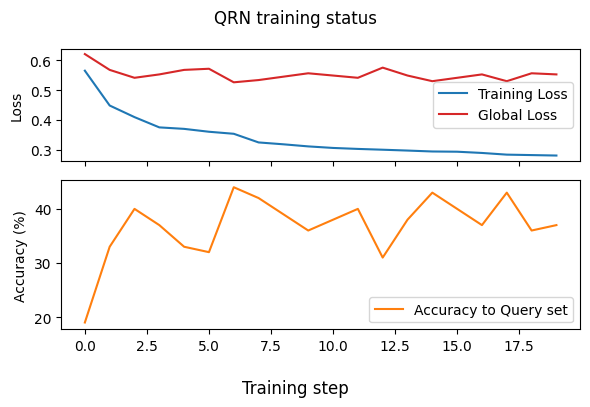

In [10]:
# Plot loss & accuracy
fig, (loss, ac) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [0.75, 1]}, figsize=(6,4))
fig.suptitle('QRN training status')
fig.supxlabel('Training step')

loss.plot(range(len(loss_list)), loss_list, label="Training Loss")
loss.plot(range(len(global_loss_list)), global_loss_list, label="Global Loss", color="C3")
loss.legend()
loss.set(ylabel='Loss')

ac.plot(range(len(acc_list)), acc_list, label="Accuracy to Query set", color="C1")
ac.set(ylabel='Accuracy (%)')
ac.legend()
fig.tight_layout();